## Working with NetCDF Files

This example notebook shows how to use `xarray` and `rioxarray` libraries to read, transform, clip, subset and plot netcdf time-series data.

In [57]:
import os
import xarray as xr
import rioxarray as rxr
import geopandas as gpd

We are using a NetCDF file of temparatures downloaded from [Climatic Research Unit (CRU): Time-series (TS) datasets](https://catalogue.ceda.ac.uk/uuid/3f8944800cc48e1cbc29a5ee12d8542d)

In [179]:
datatemp = os.path.join('data', 'Temperature_data_2011_2020.nc')

While `rioxarray` is able to read the NetCDF file, we need to supply it with some additional options.

In [187]:
ds = rxr.open_rasterio(datatemp, decode_times=False, masked=True)

The dataset is in EPSG:4326, so we write the CRS

In [188]:
ds.rio.write_crs('epsg:4326', inplace=True)

<xarray.Dataset>
Dimensions:      (y: 360, x: 720, time: 120)
Coordinates:
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time         (time) float64 4.056e+04 4.059e+04 ... 4.415e+04 4.418e+04
    spatial_ref  int64 0
Data variables:
    tmp          (time, y, x) float32 ...
    stn          (time, y, x) float64 ...
Attributes:
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk
    Conventions:  CF-1.4
    history:      Fri  5 Mar 13:25:53 GMT 2021 : User harry : Program makegri...
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    references:   Information on the data is available at http://badc.nerc.ac...
    source:       Run ID = 2103051243. Data generated from:tmp.2103041709.dtb
    title:        CRU TS4.05 Mean Temperature

The timestamps are stored as floating point numbers with days since 1900-01-01 as shown in the metadata

In [189]:
ds['time'].head()

<xarray.DataArray 'time' (time: 5)>
array([40557., 40587., 40616., 40647., 40677.])
Coordinates:
  * time         (time) float64 4.056e+04 4.059e+04 ... 4.065e+04 4.068e+04
    spatial_ref  int64 0
Attributes:
    calendar:   gregorian
    long_name:  time
    units:      days since 1900-1-1

We use `xarray.decode_cf` to convert these to python datetime objects based onstandard CF convesion

In [192]:
ds = xr.decode_cf(ds)
ds['time'].head()

<xarray.DataArray 'time' (time: 5)>
array(['2011-01-16T00:00:00.000000000', '2011-02-15T00:00:00.000000000',
       '2011-03-16T00:00:00.000000000', '2011-04-16T00:00:00.000000000',
       '2011-05-16T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2011-01-16 2011-02-15 ... 2011-05-16
    spatial_ref  int64 ...
Attributes:
    long_name:  time

We can also clip this data using a geopandas GeoDataFrame. We read a shapefile of India boundary provided by [Survey of India](https://surveyofindia.gov.in/pages/downloads) and use it to extract data for India.

In [195]:
boundaries = os.path.join('data', 'polymap15m_area.shp')
boundary_gdf = gpd.read_file(boundaries)

To clip the netcdf data, we need to reproject the vector data to the same projection.

In [197]:
boundary_gdf = boundary_gdf.to_crs('epsg:4326')

Dissolve the features to get the polygon representing the country. Extract and clip the data to this polygon.

In [198]:
geometry = boundary_gdf.dissolve(by='Id').geometry
clipped = ds.rio.clip(geometry, boundary_gdf.crs)

We can extract a subset from the xarray dataset using the `time` label. Here we extract all data for the month of May.

In [199]:
summer = clipped.sel(time = clipped['time.month']==5)

Calculate the average of summer temaratures from the time-series

In [172]:
mean = summer['tmp'].mean('time')

Plot the resulting ar

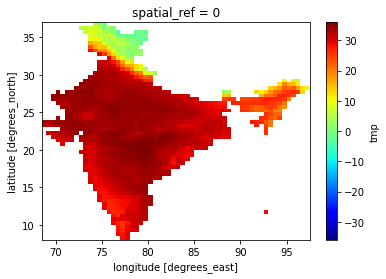

In [173]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure()

# 111 means 1 row, 1 col and index 1
ax = fig.add_subplot(111)

mean.plot(ax=ax,  cmap='jet')

plt.show()